
### This notebook details the building of a CNN model that classifies (PTB Diagnostic Database) ECG data.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

The chosen dataset is the [the PTB Diagnostic ECG Dataset](https://www.physionet.org/content/ptbdb/1.0.0/)

### Importing the required libraries

In [ ]:
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report,auc
from sklearn.metrics import precision_recall_curve,roc_auc_score,roc_curve
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import label_binarize

from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

# Set seed
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import random
import warnings
warnings.filterwarnings('ignore')

### Loading training data

In [ ]:
abnormal = pd.read_csv('ptbdb_abnormal.csv',header=None)
normal = pd.read_csv('ptbdb_normal.csv',header=None)

## Merging two dataframes

In [ ]:
dataset = abnormal.append([normal])

In [ ]:
dataset.shape

(14552, 188)

In [ ]:
# Changing target variable name for better readability
dataset = dataset.rename(columns = {187 : 'label'})

In [ ]:
# Also changing the data type for label from float to integer
dataset['label'] = dataset['label'].astype('uint8')

In [ ]:
X = dataset.drop('label', axis=1)
y = dataset['label']

In [ ]:
# Split X into train (80%), val (10%), & test (10%) sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state=42)

print(f'Train dataset : {x_train.shape} & {y_train.shape}')
print(f'Test dataset : {x_test.shape} & {y_test.shape}')
print(f'Validation dataset : {x_val.shape} & {y_val.shape}')

Train dataset : (11641, 187) & (11641,)
Test dataset : (1455, 187) & (1455,)
Validation dataset : (1456, 187) & (1456,)


The training set has 11641 rows & 187 columns. The target set for train is y_train that is either abnormal or normal – it is a binary classification task that tries to detect whether a signal is heatlhy or not:

0 — Abnormal beats     
1 — Normal beats    

['A': 0, 'N': 1,]

In [ ]:
class_names = ['A','N']

In [ ]:
# Reset index
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.944486,0.507877,0.195049,0.188297,0.120030,0.077269,0.053263,0.078770,0.042011,0.057764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.947833,0.946228,1.000000,0.768860,0.473515,0.246388,0.194222,0.182986,0.176565,0.212681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.979106,0.715909,0.354839,0.129032,0.047287,0.104472,0.155059,0.152493,0.153592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.758195,0.645199,0.401080,0.150791,0.134593,0.060162,0.042422,0.037408,0.016583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.933301,0.565007,0.066699,0.152247,0.029000,0.121798,0.322378,0.441759,0.468342,0.481392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_train

0        1
1        1
2        0
3        1
4        0
        ..
11636    1
11637    0
11638    1
11639    1
11640    1
Name: label, Length: 11641, dtype: uint8

In [ ]:
x_test.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.940602,0.396266,0.079762,0.000000,0.124735,0.211286,0.246924,0.264319,0.265168,0.268986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.455185,0.416520,0.172818,0.148799,0.159344,0.164030,0.151142,0.159930,0.157586,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.976690,0.766900,0.476690,0.000000,0.095571,0.179487,0.223776,0.261072,0.272727,0.304196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.939639,0.438706,0.113255,0.019291,0.000000,0.048538,0.122589,0.161792,0.163659,0.179216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.966887,0.288447,0.245033,0.054452,0.194996,0.302428,0.289183,0.345843,0.289919,0.334805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_test

0       0
1       1
2       1
3       1
4       1
       ..
1450    1
1451    1
1452    0
1453    0
1454    1
Name: label, Length: 1455, dtype: uint8

In [ ]:
x_val.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.975768,0.810284,0.735816,0.487589,0.176123,0.087470,0.017139,0.002955,0.000000,0.091608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.984338,1.000000,0.981989,0.931872,0.888019,0.841034,0.767424,0.724354,0.665623,0.671887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.932685,0.578834,0.298056,0.089273,0.055436,0.100792,0.140029,0.137509,0.133549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.520283,0.193174,0.000000,0.184804,0.197038,0.097875,0.215712,0.088860,0.155827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.955750,0.737633,0.449802,0.234607,0.140680,0.168441,0.168023,0.158213,0.157796,0.156961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y_val

0       1
1       1
2       0
3       1
4       0
       ..
1451    0
1452    1
1453    1
1454    1
1455    1
Name: label, Length: 1456, dtype: uint8

#### Now seeing how our target variables are distributed in the training data.

In [ ]:
#class count
df_class=y_train.value_counts()
print('Count of classes :\n',df_class)
#Percentages per class count
per_class=y_train.value_counts()/len(y_train)*100
print('percentage of count of classes :\n',per_class)

Count of classes :
 1    8357
0    3284
Name: label, dtype: int64
percentage of count of classes :
 1    71.789365
0    28.210635
Name: label, dtype: float64


Text(0, 0.5, 'Index')

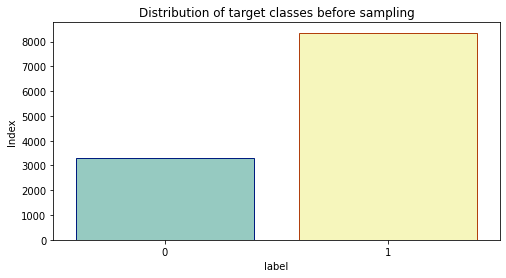

In [ ]:
#Countplot
plt.figure(figsize=(8,4))
sns.countplot(y_train, palette='Set3',edgecolor=sns.color_palette("dark", 15))
plt.title('Distribution of target classes before sampling')
plt.xlabel('label')
plt.ylabel('Index')

It seems the classes in target variable are highly imbalanced. We need to balance the classes. We are using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

### **Handling imbalanced data**
Since our data is imbalanced, we need to balance the data in order to get more accurate results from the ML model. To balance the data, I have chosen SMOTE (Synthetic Minority OverSampling Technique). SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

**This balancing should be carried out on training data only if the classes are imbalanced.**

Additional details on SMOTE can be found [here](https://arxiv.org/abs/1106.1813/)

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter= Counter(y_train)
print(f'Before Sampling', counter)
# Oversampling the training data using SMOTE
smt=SMOTE()
X_train_sm,y_train_sm = smt.fit_resample(x_train,y_train)
counter= Counter(y_train_sm)
print('After Sampling', counter)

Before Sampling Counter({1: 8357, 0: 3284})
After Sampling Counter({1: 8357, 0: 8357})


#### Distribution of target classes after SMOTE sampling

Text(0, 0.5, 'Index')

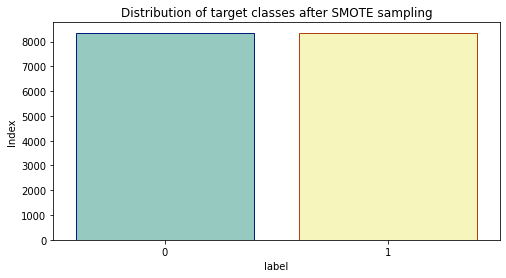

In [ ]:
#Countplot
plt.figure(figsize=(8,4))
sns.countplot(y_train_sm,palette='Set3',edgecolor=sns.color_palette("dark", 15))
plt.title('Distribution of target classes after SMOTE sampling')
plt.xlabel('label')
plt.ylabel('Index')

**A visual peek into different classes of heartbeats**

In [ ]:
# Defining a function to plot class distribution
def class_distribution(df, class_label, index):
    # Create a dataframe for class_label
    df = df[df.label== class_label]
    # Reset index
    df = df.reset_index(drop=True)
    # Drop label column from df
    df_new = df.drop('label',axis=1)
    # Considering
    df_array = df_new.loc[index,:]
    return df_array

Text(0, 0.5, 'Abnormal beats')

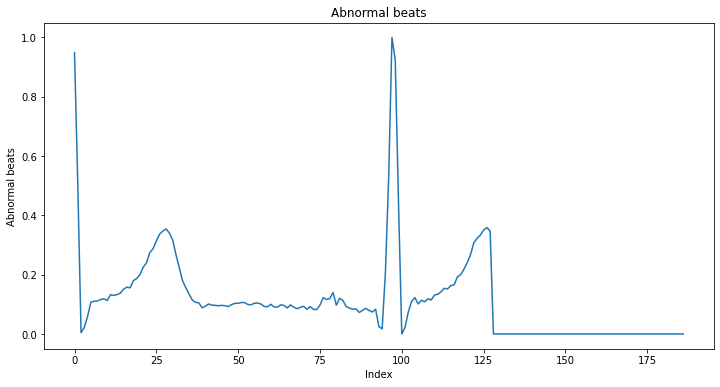

In [ ]:
# 0 — Abnormal beats
plt.figure(figsize = (12,6))
neb_df = class_distribution(dataset, 0 , 5)   # Signal corressponding to the index 5 is considered for all plots
plt.plot(neb_df.index, neb_df.values)
plt.title('Abnormal beats')
plt.xlabel('Index')
plt.ylabel('Abnormal beats')

Text(0, 0.5, 'Normal beats')

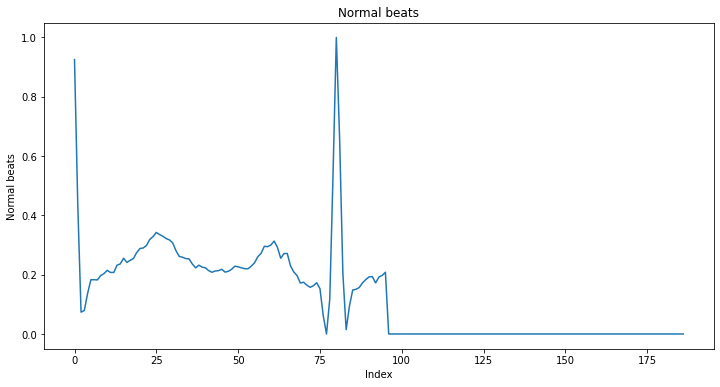

In [ ]:
# 1 — Normal beats
plt.figure(figsize = (12,6))
seb_df = class_distribution(dataset, 1 , 5)   # Signal corressponding to the index 5 is considered for all plots
plt.plot(seb_df.index, seb_df.values)
plt.title('Normal beats')
plt.xlabel('Index')
plt.ylabel('Normal beats')

#### Preprocessing

**Adding noise**   
Noise is added to the data to mimic the external random processes that can interfere in the data recording process. Additive white Gaussian noise (AWGN) model is  used for this task.

In [ ]:
import numpy as np
pure = np.linspace(-1, 1, 187)

In [ ]:
pure

array([-1.        , -0.98924731, -0.97849462, -0.96774194, -0.95698925,
       -0.94623656, -0.93548387, -0.92473118, -0.91397849, -0.90322581,
       -0.89247312, -0.88172043, -0.87096774, -0.86021505, -0.84946237,
       -0.83870968, -0.82795699, -0.8172043 , -0.80645161, -0.79569892,
       -0.78494624, -0.77419355, -0.76344086, -0.75268817, -0.74193548,
       -0.7311828 , -0.72043011, -0.70967742, -0.69892473, -0.68817204,
       -0.67741935, -0.66666667, -0.65591398, -0.64516129, -0.6344086 ,
       -0.62365591, -0.61290323, -0.60215054, -0.59139785, -0.58064516,
       -0.56989247, -0.55913978, -0.5483871 , -0.53763441, -0.52688172,
       -0.51612903, -0.50537634, -0.49462366, -0.48387097, -0.47311828,
       -0.46236559, -0.4516129 , -0.44086022, -0.43010753, -0.41935484,
       -0.40860215, -0.39784946, -0.38709677, -0.37634409, -0.3655914 ,
       -0.35483871, -0.34408602, -0.33333333, -0.32258065, -0.31182796,
       -0.30107527, -0.29032258, -0.27956989, -0.2688172 , -0.25

In [ ]:

noise = np.random.normal(0, 1, 187)
signal = pure + noise

In [ ]:
noise

array([ 2.56754927e-01, -3.81306844e-01,  1.03688647e+00,  6.71735591e-01,
        5.10560824e-01,  1.00613131e+00, -2.21925619e+00, -1.23398719e+00,
        1.82844569e+00, -1.33442603e+00,  6.07578503e-01, -3.18585100e-01,
       -6.43215162e-01,  1.74383088e+00, -4.96408930e-01, -3.21913211e+00,
       -5.40203126e-02, -1.11090153e-01, -1.48949482e-01, -8.27825449e-01,
       -2.16314501e+00,  5.70546194e-01, -1.50053892e+00, -3.18842113e-02,
       -1.07478136e+00,  2.37305166e-01,  6.20547140e-01,  1.05460083e+00,
        6.51202482e-01,  1.13064231e+00, -1.76067909e-01, -6.51932430e-01,
       -1.02158962e+00, -1.08990775e+00,  9.53139553e-01,  3.44586991e-01,
       -1.03495140e+00,  9.32469908e-01,  1.45151551e+00,  3.48446812e-03,
       -1.60060082e+00,  1.46122016e+00, -6.01541360e-01,  4.06692130e-01,
       -6.47104694e-01,  7.00981990e-01, -1.02083533e+00, -3.49186387e-01,
       -2.58355373e-01, -6.88533649e-02, -6.39971309e-01,  1.13992368e+00,
        1.29713302e+00, -

In [ ]:
signal

array([-0.74324507, -1.37055416,  0.05839185, -0.29600634, -0.44642842,
        0.05989475, -3.15474006, -2.15871837,  0.9144672 , -2.23765184,
       -0.28489462, -1.20030553, -1.5141829 ,  0.88361582, -1.3458713 ,
       -4.05784178, -0.8819773 , -0.92829445, -0.95540109, -1.62352437,
       -2.94809125, -0.20364735, -2.26397978, -0.78457238, -1.81671685,
       -0.49387763, -0.09988297,  0.34492341, -0.04772225,  0.44247026,
       -0.85348726, -1.3185991 , -1.6775036 , -1.73506904,  0.31873095,
       -0.27906892, -1.64785463,  0.33031937,  0.86011766, -0.57716069,
       -2.17049329,  0.90208037, -1.14992846, -0.13094228, -1.17398641,
        0.18485296, -1.52621167, -0.84381004, -0.74222634, -0.54197164,
       -1.1023369 ,  0.68831078,  0.8562728 , -1.69692117, -0.4213781 ,
       -0.00857435, -1.32797972, -0.62891273, -1.04963833, -1.412829  ,
        0.29899798,  0.28679687,  0.36800442,  0.7821357 , -0.89302437,
       -0.41152883, -0.84101704,  0.7617416 , -1.07853261, -0.30

In [ ]:
# adding noise to make data more realistic
def gaussian_noise(signal):
    noise = np.random.normal(0,0.05,187)
    return signal + noise


# Input to the model
X_train_sm = X_train_sm.values
# Adding noise
for i in range(X_train_sm.shape[0]):
    X_train_sm[i, :] = gaussian_noise(X_train_sm[i, :])

# Converting X_train into dataframe
X_train = pd.DataFrame(X_train_sm)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.949831,0.507966,0.224458,0.343892,0.119650,0.133028,0.112412,0.020578,0.011321,0.125480,...,-0.068168,-0.018549,-0.054535,0.011049,-0.071616,-0.030380,0.030590,0.044672,-0.076101,0.059347
1,0.958642,1.054360,0.982348,0.813347,0.494381,0.182130,0.205824,0.221335,0.203007,0.237710,...,-0.059139,-0.116710,-0.000044,-0.002725,-0.112505,-0.077437,0.057307,0.025240,0.019750,-0.018058
2,1.047526,0.922102,0.806111,0.435689,0.182796,0.013342,0.138919,0.118845,0.180900,0.218877,...,-0.068781,-0.000809,0.003612,-0.076577,-0.013747,0.009749,-0.018470,0.075980,-0.075845,0.001276
3,1.037283,0.762214,0.602138,0.398776,0.227342,0.203089,0.023798,0.105514,0.004084,0.014028,...,0.012211,0.071033,0.066689,-0.076686,-0.030175,0.103179,-0.019738,-0.014968,0.017922,-0.031484
4,0.923956,0.656318,0.125165,0.220369,0.031108,0.064510,0.315160,0.369677,0.476714,0.481027,...,-0.002635,-0.073836,0.042867,0.024373,0.016200,0.021826,0.041502,0.055798,-0.054840,-0.005645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,0.949357,0.726461,0.168740,0.030428,0.112034,0.068668,0.099215,0.019317,0.082334,0.066939,...,-0.008061,-0.122163,0.091744,-0.095406,0.069388,0.081378,-0.035618,0.070084,-0.003984,0.071311
16710,0.992138,0.857436,0.574144,0.386196,0.214214,0.178834,0.031594,0.105707,0.166533,0.092820,...,0.041474,0.008779,0.048600,-0.045885,-0.029813,0.021795,0.052503,-0.056580,-0.026150,0.020943
16711,0.986715,1.063374,0.490070,0.188196,0.066090,0.095258,0.158770,0.154047,0.168351,0.164435,...,-0.020076,-0.013174,0.028378,-0.006058,0.067483,0.095306,-0.007412,0.040110,0.005177,0.071181
16712,1.003591,0.926324,0.397134,0.212728,-0.015741,0.134774,0.264930,0.210968,0.291697,0.294871,...,-0.039747,0.026470,0.070912,0.062654,0.004774,0.005029,-0.102395,-0.032026,0.041123,0.021022


**Here is a sample signal with added noise**

In [ ]:
x_sample = X_train.loc[5,:]
x_original = x_train.loc[5,:]

In [ ]:
x_sample

0      1.039736
1      0.571771
2      0.133149
3      0.050509
4      0.055055
         ...   
182    0.069491
183    0.000338
184   -0.029371
185    0.055361
186    0.059809
Name: 5, Length: 187, dtype: float64

In [ ]:
x_original

0      1.000000
1      0.579439
2      0.120872
3      0.039252
4      0.037383
         ...   
182    0.000000
183    0.000000
184    0.000000
185    0.000000
186    0.000000
Name: 5, Length: 187, dtype: float64

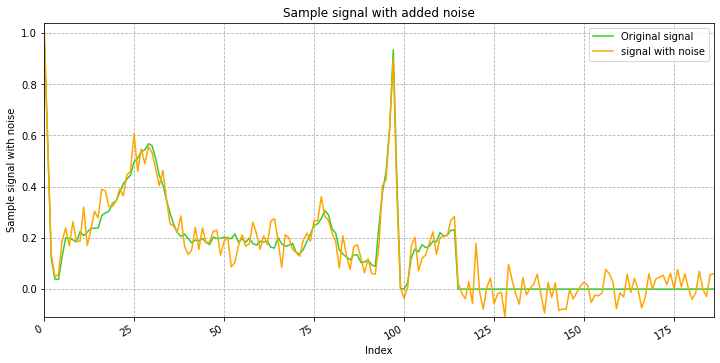

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(x_original.index, x_original.values, color = 'limegreen', label='Original signal')
plt.plot(x_sample.index, x_sample.values,color='orange', label='signal with noise')
plt.title('Sample signal with added noise')
plt.xlabel('Index')
plt.ylabel('Sample signal with noise')

plt.gcf().autofmt_xdate()   # Beautify the x-labels
plt.autoscale(tight=True)

plt.legend(loc='best')
plt.grid(True, linestyle='dashed')

### Normalizing the data

In [ ]:
from sklearn.preprocessing import  QuantileTransformer
# Scale our continuous data in the range of 0 & 1
# define min max scaler
scaler = QuantileTransformer(output_distribution='normal')
# fit & transform data
x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

### Encoding the target classes with One hot coding

In [ ]:
# One hot encoding the output of the model
y_train = to_categorical(y_train_sm)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
y_train.shape

(16714, 2)

In [ ]:
X_train.shape

(16714, 187)

Reshape the X_train, & X_test from (n_samples, n_features) to (n_samples, number of time steps, n_features) - CNN input format

In [ ]:
x_train_scaled.shape[0]

16714

In [ ]:
x_train_scaled.shape[1]

187

In [ ]:
X_train =x_train_scaled.reshape(x_train_scaled.shape[0], 1, x_train_scaled.shape[1])   # number of time steps is 1
X_val =x_val_scaled.reshape(x_val_scaled.shape[0], 1, x_val_scaled.shape[1])   # number of time steps is 1
X_test = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])     # number of time steps is 1

In [ ]:
n_classes = y_train.shape[1]
n_classes

2

## Building our CNN model

The model has three Convolution1D layers & two Dropout layers. This is then followed by 2 Dense layers, two of which have ReLU activation function while the last layer has 2 nodes, corresponding to the 2 output class labels, with a Softmax activation function.   
The softmax activation function is used for binary data.

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(1, 187)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',padding='same'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))    # Fully connected layer
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))    # Fully connected layer
model.add(Flatten())
model.add(Dense(n_classes, activation='sigmoid'))

In [ ]:
# Compile model
model.compile(optimizer = Adam(0.001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

In [ ]:
print('Model summary')
print(model.summary())

print("inputs: " , model.input_shape)
print("outputs: ", model.output_shape)
print("actual inputs: ", np.shape(X_train))
print("actual outputs: ", np.shape(y_train))

Model summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 128)            71936     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             24640     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             12352     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 64)             4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)

### Plotting the model

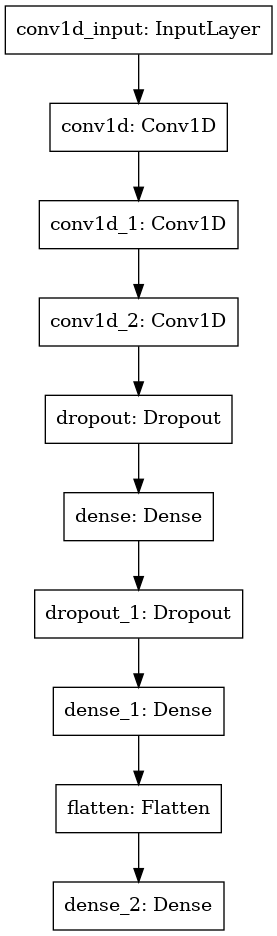

In [ ]:
from IPython.display import Image
from keras.utils.vis_utils import model_to_dot

Image(model_to_dot(model).create(prog='dot', format='png'))

### Training the model



In [ ]:
batch_size = 16

history=model.fit(X_train, y_train, batch_size=batch_size,epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
1045/1045 [==============================] - 3s 3ms/step - loss: 0.4035 - accuracy: 0.8239 - val_loss: 0.2430 - val_accuracy: 0.8935
Epoch 2/20
1045/1045 [==============================] - 2s 2ms/step - loss: 0.2537 - accuracy: 0.8989 - val_loss: 0.1676 - val_accuracy: 0.9306
Epoch 3/20
1045/1045 [==============================] - 3s 2ms/step - loss: 0.1958 - accuracy: 0.9243 - val_loss: 0.1383 - val_accuracy: 0.9437
Epoch 4/20
1045/1045 [==============================] - 2s 2ms/step - loss: 0.1581 - accuracy: 0.9387 - val_loss: 0.1285 - val_accuracy: 0.9505
Epoch 5/20
1045/1045 [==============================] - 2s 2ms/step - loss: 0.1341 - accuracy: 0.9507 - val_loss: 0.1225 - val_accuracy: 0.9471
Epoch 6/20
1045/1045 [==============================] - 2s 2ms/step - loss: 0.1091 - accuracy: 0.9589 - val_loss: 0.1237 - val_accuracy: 0.9519
Epoch 7/20
1045/1045 [==============================] - 3s 3ms/step - loss: 0.0982 - accuracy: 0.9649 - val_loss: 0.1205 - val_accuracy:

In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


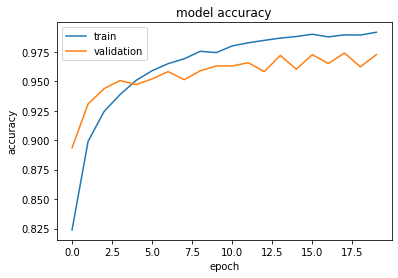

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

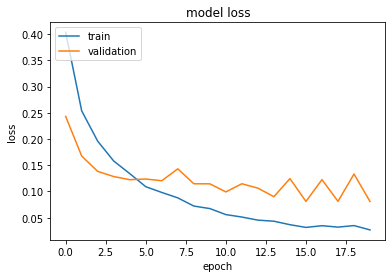

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model performance on testing data

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred_prob

array([[9.9992597e-01, 7.0396229e-05],
       [2.3555551e-09, 1.0000000e+00],
       [6.9907308e-04, 9.9906492e-01],
       ...,
       [9.9934876e-01, 7.0038438e-04],
       [9.9999899e-01, 1.0201890e-06],
       [2.2913964e-06, 9.9999595e-01]], dtype=float32)

In [ ]:
# Convert class probabilities to classes
y_pred = y_pred_prob.argmax(axis=1)
y_pred

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
y_test = y_test.argmax(axis=1)
y_test

array([0, 1, 1, ..., 0, 0, 1])

### Confusion matrix

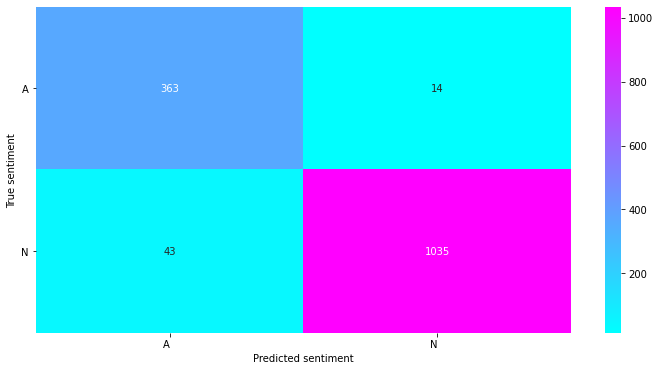

In [ ]:
def show_confusion_matrix(confusion_matrix):
  plt.figure(figsize=(12,6))
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="cool")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(),rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(),rotation=0, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
cm

array([[ 363,   14],
       [  43, 1035]])

### Classification Report

In [ ]:
class_report= classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       377
           1       0.99      0.96      0.97      1078

    accuracy                           0.96      1455
   macro avg       0.94      0.96      0.95      1455
weighted avg       0.96      0.96      0.96      1455



I was able to achieve **accuracy of 0.96 & f1_score of 0.96** for the testing data.

For imbalanced dataset, **the precision-recall curve & ROC curve** are better metrics for evaluating our model performance.

### Plot PR (Precision-Recall) curve:

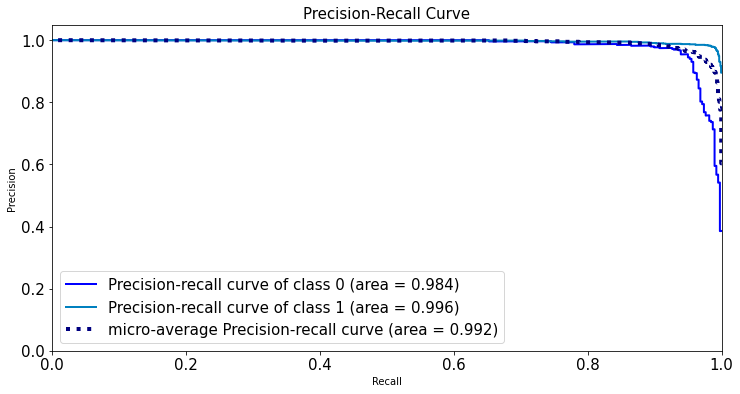

In [ ]:
# Plot PR curve
skplt.metrics.plot_precision_recall(y_test, y_pred_prob, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                                   cmap = 'winter')
plt.show()

### ROC (Receiver operating characterstic) curve:

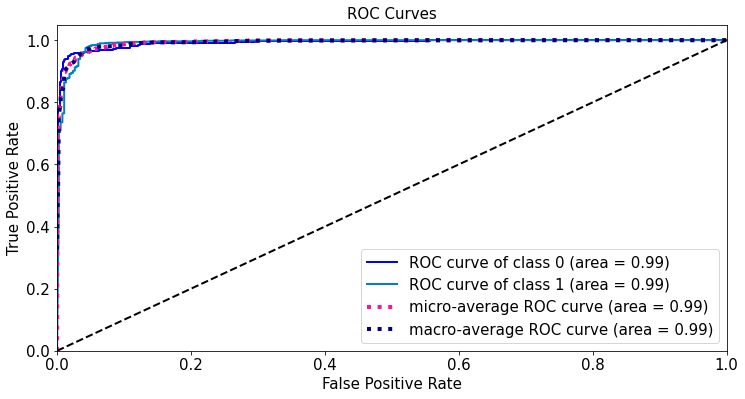

In [ ]:
# Plot ROC curve
skplt.metrics.plot_roc(y_test, y_pred_prob, figsize = (12,6), text_fontsize = 15, title_fontsize = 15,
                      cmap = 'winter')
plt.show()

### Model prediction on random signal

Let’s randomly visualize some of the heartbeat signals while performing predictions using our model.

Actual label:  A
Model prediction :  A  with probability  0.99999356


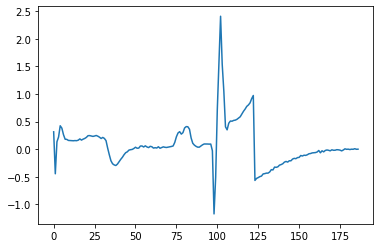

In [ ]:
i = random.randint(0, len(X_test)-1)
output = model(np.expand_dims(X_test[i], 0))
x_random = pd.DataFrame(X_test[i])
x_random = x_random.loc[0,:]
pred = output.numpy()[0]
plt.plot(x_random.index, x_random.values)
print("Actual label: ", class_names[np.argmax(y_test[i])])
print("Model prediction : ", class_names[np.argmax(pred)],
      " with probability ", pred[np.argmax(pred)])